<a href="https://colab.research.google.com/github/wei-enwang/space-ham/blob/main/main_driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import nltk
from nltk.corpus import words
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils import data
from preprocess import WholeData, BalancedData

import models
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/weinwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
nltk.download('words')

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 32
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

[nltk_data] Downloading package words to /home/weinwang/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
plot_yes = True

# use one dataset for now
train_data_dir = "./data/enron1/"
test_data_dir = "./data/enron2/"
output_dir = "./output/"

# hyperparameters
batch_size = 64
hidden_size = 128
num_layer = 3
dropout = 0.5
learning_rate = 1e-4
epochs = 30
max_len = 300

In [4]:
vocab = set([str.lower() for str in words.words()])

# train_dataset = WholeData(train_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)
# test_dataset = WholeData(test_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)
# Balanced dataset
train_dataset = BalancedData(train_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)
test_dataset = BalancedData(test_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)

w2idx = train_dataset.src_v2id

embed = utils.load_pretrained_vectors(w2idx, "fastText/crawl-300d-2M.vec")
embed = torch.tensor(embed)

Number of ham emails: 1500, spam emails: 1500
Number of ham emails: 1496, spam emails: 1496
Loading pretrained vectors...
234378


0it [00:00, ?it/s]

There are 75835 / 234379 pretrained vectors found.


In [5]:
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                   num_workers=8, pin_memory=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, 
                                  num_workers=8, pin_memory=True, drop_last=True)


In [6]:
model = models.spam_lstm(hidden_size=hidden_size, pretrained_embedding=embed, dropout=dropout).to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)
opt = Adam(model.parameters(), lr=learning_rate)

Using pretrained vectors...


  0%|          | 0/30 [00:00<?, ?it/s]/home/weinwang/anaconda3/envs/nlp/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  3%|▎         | 1/30 [00:07<03:26,  7.13s/it]

Epoch 0
-------------------------------
Training loss: 0.693438, avg accuracy: 0.499763
Testing loss: 0.693293, avg accuracy: 0.500000


  7%|▋         | 2/30 [00:14<03:19,  7.14s/it]

Epoch 1
-------------------------------
Training loss: 0.692990, avg accuracy: 0.506222
Testing loss: 0.693237, avg accuracy: 0.480639


 10%|█         | 3/30 [00:21<03:13,  7.15s/it]

Epoch 2
-------------------------------
Training loss: 0.692884, avg accuracy: 0.488697
Testing loss: 0.693482, avg accuracy: 0.475543


 13%|█▎        | 4/30 [00:28<03:06,  7.15s/it]

Epoch 3
-------------------------------
Training loss: 0.690938, avg accuracy: 0.506886
Testing loss: 0.699262, avg accuracy: 0.501019


 17%|█▋        | 5/30 [00:35<02:58,  7.15s/it]

Epoch 4
-------------------------------
Training loss: 0.681709, avg accuracy: 0.522891
Testing loss: 0.709664, avg accuracy: 0.486413


 20%|██        | 6/30 [00:42<02:51,  7.14s/it]

Epoch 5
-------------------------------
Training loss: 0.670247, avg accuracy: 0.541888
Testing loss: 0.717496, avg accuracy: 0.493207


 23%|██▎       | 7/30 [00:50<02:44,  7.15s/it]

Epoch 6
-------------------------------
Training loss: 0.669371, avg accuracy: 0.554854
Testing loss: 0.694683, avg accuracy: 0.497622


 27%|██▋       | 8/30 [00:57<02:37,  7.16s/it]

Epoch 7
-------------------------------
Training loss: 0.659175, avg accuracy: 0.550152
Testing loss: 0.710046, avg accuracy: 0.500000


 30%|███       | 9/30 [01:04<02:30,  7.16s/it]

Epoch 8
-------------------------------
Training loss: 0.651850, avg accuracy: 0.559888
Testing loss: 0.707627, avg accuracy: 0.511209


 33%|███▎      | 10/30 [01:11<02:23,  7.16s/it]

Epoch 9
-------------------------------
Training loss: 0.643880, avg accuracy: 0.559935
Testing loss: 0.721525, avg accuracy: 0.516644


 37%|███▋      | 11/30 [01:18<02:15,  7.16s/it]

Epoch 10
-------------------------------
Training loss: 0.635333, avg accuracy: 0.582779
Testing loss: 0.706590, avg accuracy: 0.531590


 40%|████      | 12/30 [01:25<02:08,  7.16s/it]

Epoch 11
-------------------------------
Training loss: 0.551744, avg accuracy: 0.724877
Testing loss: 0.741704, avg accuracy: 0.729620


 43%|████▎     | 13/30 [01:33<02:01,  7.17s/it]

Epoch 12
-------------------------------
Training loss: 0.476943, avg accuracy: 0.785334
Testing loss: 0.653851, avg accuracy: 0.731997


 47%|████▋     | 14/30 [01:40<01:54,  7.16s/it]

Epoch 13
-------------------------------
Training loss: 0.472436, avg accuracy: 0.787377
Testing loss: 0.649653, avg accuracy: 0.732337


 50%|█████     | 15/30 [01:47<01:47,  7.15s/it]

Epoch 14
-------------------------------
Training loss: 0.470845, avg accuracy: 0.792981
Testing loss: 0.677774, avg accuracy: 0.731318


 53%|█████▎    | 16/30 [01:54<01:40,  7.15s/it]

Epoch 15
-------------------------------
Training loss: 0.468518, avg accuracy: 0.792601
Testing loss: 0.636958, avg accuracy: 0.738111


 57%|█████▋    | 17/30 [02:01<01:32,  7.15s/it]

Epoch 16
-------------------------------
Training loss: 0.510876, avg accuracy: 0.743826
Testing loss: 0.770955, avg accuracy: 0.731997


 60%|██████    | 18/30 [02:08<01:25,  7.15s/it]

Epoch 17
-------------------------------
Training loss: 0.502281, avg accuracy: 0.810315
Testing loss: 0.661944, avg accuracy: 0.710598


 63%|██████▎   | 19/30 [02:15<01:18,  7.16s/it]

Epoch 18
-------------------------------
Training loss: 0.482474, avg accuracy: 0.809555
Testing loss: 0.671974, avg accuracy: 0.706522


 67%|██████▋   | 20/30 [02:23<01:11,  7.17s/it]

Epoch 19
-------------------------------
Training loss: 0.479915, avg accuracy: 0.808178
Testing loss: 0.651026, avg accuracy: 0.720109


 70%|███████   | 21/30 [02:30<01:04,  7.17s/it]

Epoch 20
-------------------------------
Training loss: 0.476844, avg accuracy: 0.803097
Testing loss: 0.666480, avg accuracy: 0.723845


 73%|███████▎  | 22/30 [02:37<00:57,  7.17s/it]

Epoch 21
-------------------------------
Training loss: 0.492564, avg accuracy: 0.803524
Testing loss: 0.796713, avg accuracy: 0.642663


 77%|███████▋  | 23/30 [02:44<00:50,  7.17s/it]

Epoch 22
-------------------------------
Training loss: 0.528176, avg accuracy: 0.782817
Testing loss: 0.630821, avg accuracy: 0.687160


 80%|████████  | 24/30 [02:51<00:43,  7.17s/it]

Epoch 23
-------------------------------
Training loss: 0.498780, avg accuracy: 0.800057
Testing loss: 0.644110, avg accuracy: 0.690557


 83%|████████▎ | 25/30 [02:58<00:35,  7.17s/it]

Epoch 24
-------------------------------
Training loss: 0.496488, avg accuracy: 0.802194
Testing loss: 0.633848, avg accuracy: 0.696332


 87%|████████▋ | 26/30 [03:06<00:28,  7.16s/it]

Epoch 25
-------------------------------
Training loss: 0.492931, avg accuracy: 0.804284
Testing loss: 0.638354, avg accuracy: 0.695652


 90%|█████████ | 27/30 [03:13<00:21,  7.17s/it]

Epoch 26
-------------------------------
Training loss: 0.485745, avg accuracy: 0.809176
Testing loss: 0.628503, avg accuracy: 0.709918


 93%|█████████▎| 28/30 [03:20<00:14,  7.18s/it]

Epoch 27
-------------------------------
Training loss: 0.498895, avg accuracy: 0.779445
Testing loss: 0.682150, avg accuracy: 0.572690


 97%|█████████▋| 29/30 [03:27<00:07,  7.17s/it]

Epoch 28
-------------------------------
Training loss: 0.622676, avg accuracy: 0.611227
Testing loss: 0.635522, avg accuracy: 0.589334


100%|██████████| 30/30 [03:34<00:00,  7.16s/it]

Epoch 29
-------------------------------
Training loss: 0.565166, avg accuracy: 0.673917
Testing loss: 0.629524, avg accuracy: 0.639606


Final testing loss: 0.623469, testing accuracy: 0.642663
Ham Precision: 0.588913, Recall: 0.940095, F1 score: 0.724174.
Ham Precision: 0.853088, Recall: 0.346441, F1 score: 0.492768.


(0.5651659229968456, 0.6234694252843442)

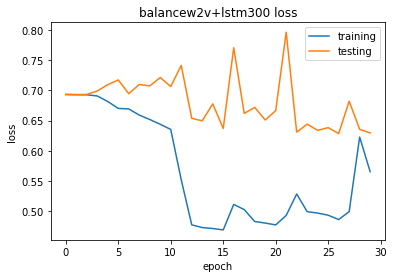

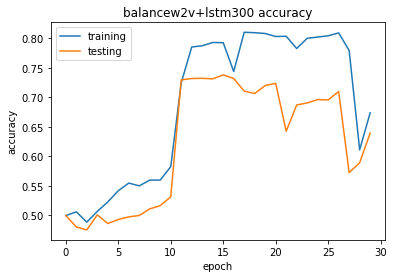

In [7]:
utils.train_test_scheme(train_dataloader, test_dataloader, model, loss_fn, opt, 
                        task_name="balancew2v+lstm300", epochs=epochs, 
                        vis=plot_yes, print_every=1, img_dir=output_dir)



In [8]:
#torch.save(model.state_dict(), output_dir+"balancew2v_lstm100batch32.pt")

In [9]:
#test_message = "Subject: Look, I understand everything, but this is a frank bust... Look here and tell me your opinion"

In [10]:
# from preprocess import clean_string
# context = clean_string(test_message)
# sent_id = [0 for _ in range(max_len)]
# for i, w in enumerate(context):
#     if i >= max_len:
#         break
#     if w not in train_dataset.vocab:
#         w = '<unk>'
#     sent_id[i] = train_dataset.src_v2id[w]
# sent_id = torch.unsqueeze(torch.tensor(sent_id),dim=0).to(device)

In [11]:
# model.eval()
# print(f"Email message: \"{test_message}\"")
# with torch.no_grad():
#     pred = nn.Sigmoid()(model(sent_id))
#     pred = torch.squeeze(pred)

#     if pred > 0.5:
#         print("This is a ham email message.")
#     else:
#         print("This is a spam email message.")

# print(f"The probability of this email being a spam is {(1-pred)*100:.1f}%.")